# About data

### Description:

The NASA-USDA Global soil moisture and the NASA-USDA SMAP Global soil moisture datates provide soil moisture information across the globe at 0.25°x0.25° spatial resolution. These datasets include surface and subsurface soil moisture (mm), soil moisture profile (%), and surface and subsurface soil moisture anomalies. Soil moisture anomalies are unitless and represent standardized anomalies computed using a 31-days moving window. Values around 0 indicate typical moisture conditions, while very positive and very negative values indicate extreme wetting (soil moisture conditions are above average) and drying (soil moisture conditions are below average), respectively.

This dataset is generated by integrating satellite-derived Soil Moisture Active Passive (SMAP) Level 3 soil moisture observations into the modified two-layer Palmer model using a 1-D Ensemble Kalman Filter (EnKF) data assimilation approach. The assimilation of the SMAP soil moisture observations helped improve the model-based soil moisture predictions particularly over poorly instrumented areas of the world that lack good quality precipitation data.

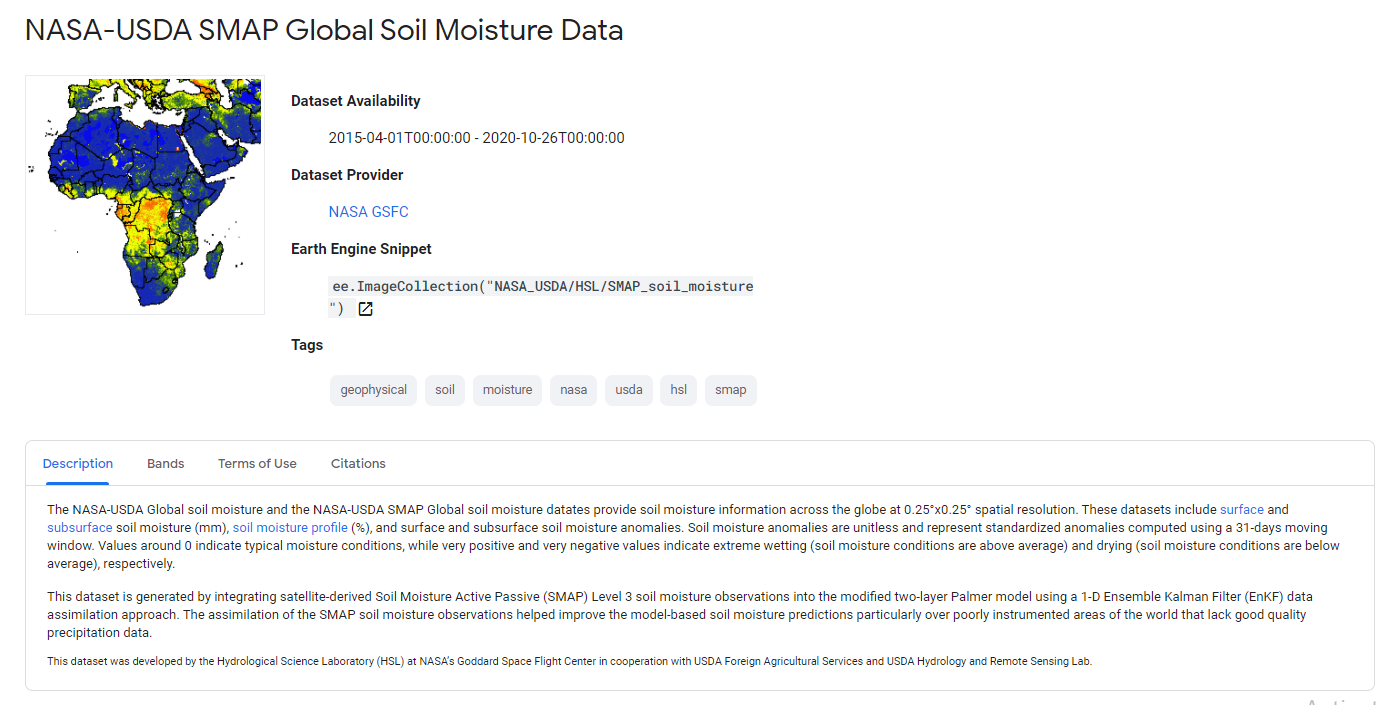

### Bands

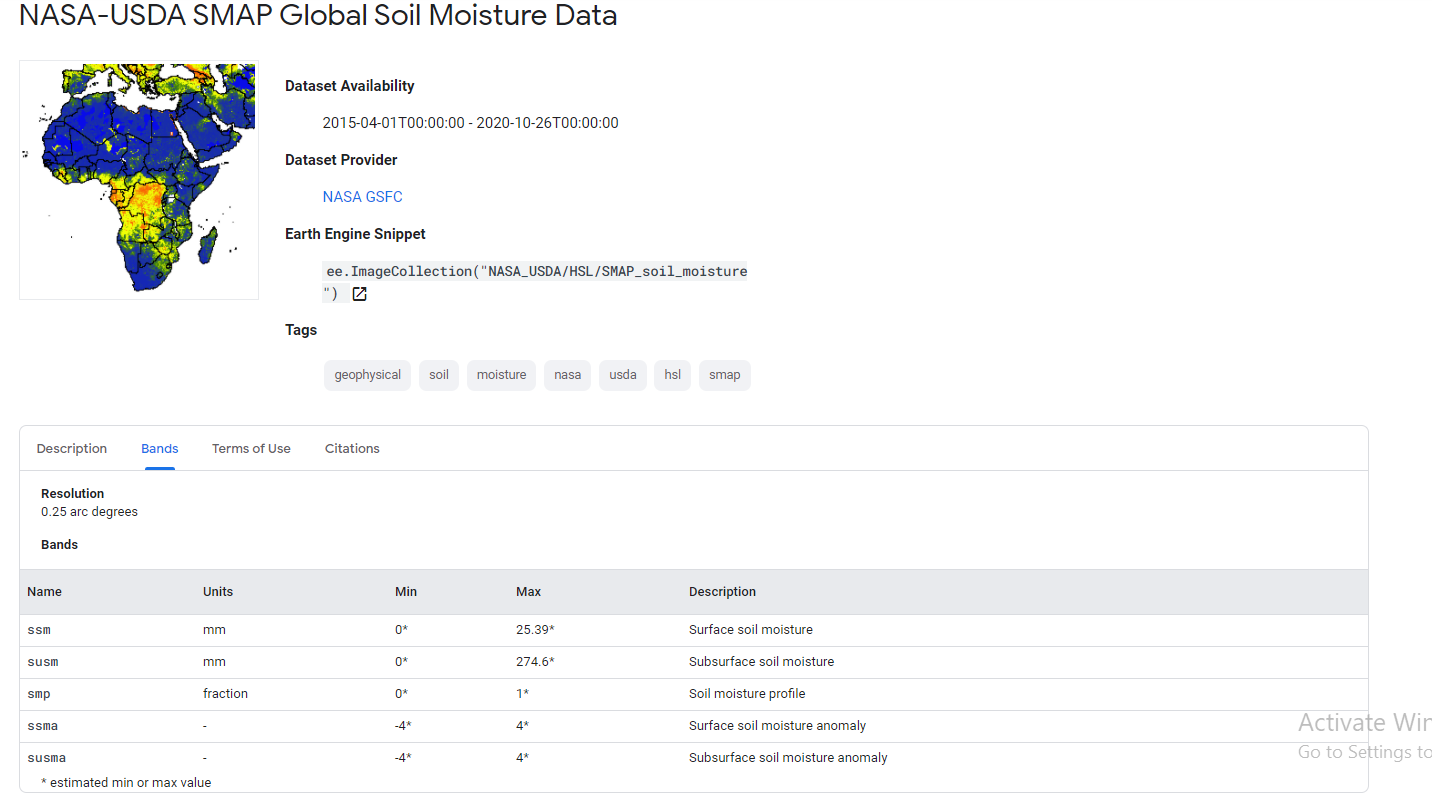

# Import required package

In [3]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/5wEUT2AiyroY_nc6TCh-BvoFGAL46VDnnwdL4Isbe6f8i5R3rpDvBkE

Successfully saved authorization token.


In [9]:
import folium
from folium import plugins
from IPython.display import Image
from ipygee import*
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.metrics import mean_squared_error
#import matplotlib.pyplot as plt

## Loading datasets

In [10]:
dataset = ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture').filter(ee.Filter.date('2020-10-01', '2020-10-31'))

## extract sub soil moisture, unit in mm, estimated values are min:0, max:25.39 (About estimated values given in above NASA-USDA SMAP description.)

In [11]:
soilMoisture = dataset.select('ssm')

# Generating point data for banglore aoi

In [12]:
point = ee.FeatureCollection([ee.Feature(ee.Geometry.Point([77.555477566153036, 12.94127283899151]),{"system:index": "0"})])

# Creating basemap

In [13]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

# Define add_ee_layer function to add layer

In [14]:
def add_ee_layer(self, ee_object, vis_params, name):
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Generate map

In [15]:
my_map = folium.Map(location=[12.94127283899151, 77.955477566153036], zoom_start=5)
smap_param = {'min': 0.0, 'max': 28.0, 'palette': ['red', 'yellow','blue']}
# Display the map.

# Add custom basemaps

In [16]:
basemaps['Google Terrain'].add_to(my_map)

# Add soil moisture and point to map

In [17]:
my_map.add_ee_layer(soilMoisture, smap_param, 'SMAP')
my_map.add_ee_layer(point.geometry(), {}, 'Point 1')

# display map with layers

In [18]:
my_map.add_child(folium.LayerControl())
display(my_map)

In [19]:
smap =chart.Image.series(**{'imageCollection': soilMoisture,
                                   'region': point,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 20,
                                   'xProperty': 'system:time_start'})

In [25]:
smap.renderWidget(width='85%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [26]:
p1_dataframe = smap.dataframe

In [27]:
p1_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8 entries, 2020-10-02 12:00:00 to 2020-10-26 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ssm     8 non-null      float64
dtypes: float64(1)
memory usage: 128.0 bytes


In [28]:
p1_dataframe.head()

,ssm
2020-10-02 12:00:00,21.015223
2020-10-05 12:00:00,18.439409
2020-10-08 12:00:00,20.795683
2020-10-11 12:00:00,23.808603
2020-10-14 12:00:00,20.144634


In [38]:
import matplotlib
import numpy as np
#from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'r'
import matplotlib.pyplot as plt
import matplotlib.pylab as plot
plot.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 18, 8

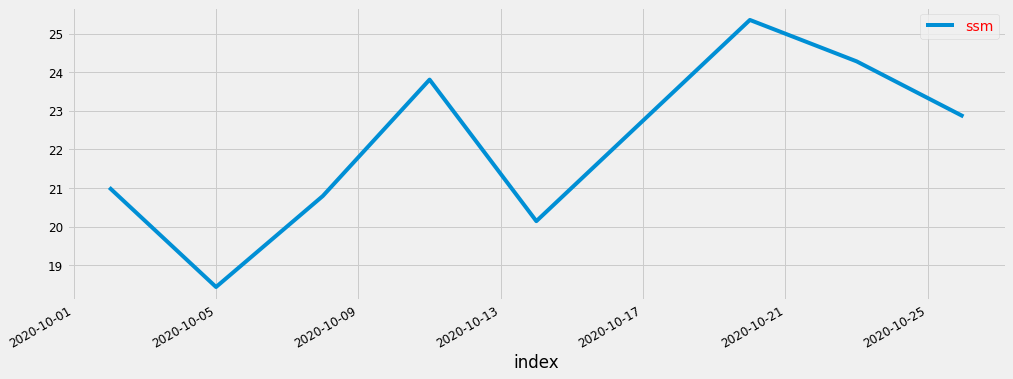

In [82]:
p1_dataframe.plot(figsize=(15, 6))
plt.show()


## Note: The analysis is done for 3 days temporal data obtained from NASA- USDA global soil moisture